
# Run pyLossless on a BIDS dataset.

In this notebook, we will run the pyLossless pipeline on a publicly available dataset.


## Imports



In [2]:
from pathlib import Path
import shutil
import pylossless as ll
import seaborn as sns

In [4]:
import pylossless
print(pylossless.__file__)

/home/zeph/Research2024/packages/pylossless/pylossless/__init__.py


## Get the data



In [5]:
raw, config, bids_path = ll.datasets.load_openneuro_bids()


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds002778 …


📁 Traversing directories for ds002778 : 20 entities [00:09,  2.21 entities/s]

📥 Retrieving up to 19 files (5 concurrent downloads). 
✅ Finished downloading ds002778.
 
🧠 Please enjoy your brains.
 


## Prep the Raw object

This data has EOG channels that are not labeled as such. We will manually set the
channel types to be "eog" for these channels (i.e. "EXG1"). We will also crop the
data to 60 seconds for speed, and load the data in memory, which is required for
running the pipeline.



In [6]:
raw.set_channel_types({ch: "eog" for ch in raw.ch_names if ch.startswith("EX")})
raw.load_data().crop(0, 60)

Reading 0 ... 97791  =      0.000 ...   190.998 secs...


<RawEDF | sub-pd6_ses-off_task-rest_eeg.bdf, 41 x 30721 (60.0 s), ~9.6 MB, data loaded>

In [ ]:
y = f(x)
y = x.f()

/tmp/ipykernel_6220/2779122189.py:2: RuntimeWarning: divide by zero encountered in log10
  sns.kdeplot(np.log10(data.ravel()[::100]))
/tmp/ipykernel_6220/2779122189.py:2: RuntimeWarning: invalid value encountered in log10
  sns.kdeplot(np.log10(data.ravel()[::100]))


np.float64(65536.0)

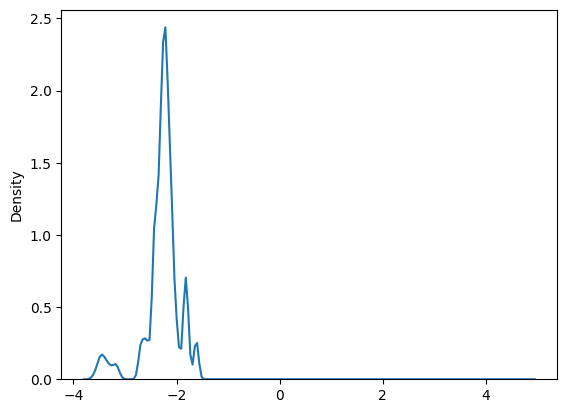

In [13]:
import numpy as np
sns.kdeplot(np.log10(data.ravel()[::100]))
data.max()

In [14]:
2**16

65536

In [10]:
x = list(range(10))
x [2:8:2]

[2, 4, 6]

## Initialize the pipeline

The :class:`~pylossless.LosslessPipeline` instance is the main object that will
run the pipeline. It takes a file path to a :class:`~pylossless.config.Config` object
as input. :func:`~pylossless.datasets.load_openneuro_bids` returned a
:class:`~pylossless.config.Config` object, so we will save it to disk and pass the
file path to the :class:`~pylossless.LosslessPipeline` constructor.



In [4]:
config_path = Path("lossless_config.yaml")
config["filtering"]["notch_filter_args"]["freqs"] = [60]
config.save(config_path)
pipeline = ll.LosslessPipeline(config_path)

## Run the pipeline

The :class:`~pylossless.LosslessPipeline` object has a
:meth:`~pylossless.LosslessPipeline.run_with_raw` method that takes a
:class:`~mne.io.Raw` object as input.
We will use the :class:`~mne.io.Raw` object that was returned by
:func:`~pylossless.datasets.load_openneuro_bids` with the pipeline.



In [ ]:
pipeline.run_with_raw(raw)

NameError: name 'pipeline' is not defined

## View the results

The :class:`~pylossless.LosslessPipeline` object stores flagged channels and ICs in
the :attr:`~pylossless.LosslessPipeline.flags` attribute:



In [6]:
pipeline

🔄 Request timed out while downloading /home/zeph/Research2024/ds002778/CHANGES, retrying in 0.5 sec …
🔄 Request timed out while downloading /home/zeph/Research2024/ds002778/dataset_description.json, retrying in 0.5 sec …
🔄 Request timed out while downloading /home/zeph/Research2024/ds002778/README, retrying in 0.5 sec …
🔄 Request timed out while downloading /home/zeph/Research2024/ds002778/participants.tsv, retrying in 0.5 sec …
🔄 Request timed out while downloading /home/zeph/Research2024/ds002778/participants.json, retrying in 0.5 sec …


Raw,"('/home/zeph/Research2024/ds002778/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_eeg.bdf',)"
Config,lossless_config.yaml
Noisy,[]
Bridged,['PO3' 'O1' 'Oz' 'O2' 'PO4']
Uncorrelated,[]
EOG (Eye),"['ICA000', 'ICA001', 'ICA013', 'ICA017']"
ECG (Heart),[]
Muscle,"['ICA002', 'ICA004', 'ICA005', 'ICA008']"
Line Noise,[]
Channel Noise,[]
BAD_LL_noisy,1.00 s seconds


In [7]:
pipeline.flags["ic"]

,component,annotator,ic_type,confidence
0,ICA000,ic_label,eog,0.999322
1,ICA001,ic_label,eog,0.471219
2,ICA002,ic_label,muscle,0.999597
3,ICA003,ic_label,brain,0.998710
4,ICA004,ic_label,muscle,0.963688
5,ICA005,ic_label,muscle,0.998467
6,ICA006,ic_label,brain,0.999827
7,ICA007,ic_label,brain,0.913452
8,ICA008,ic_label,muscle,0.999979
9,ICA009,ic_label,other,0.840520


## Get the cleaned data

The :class:`~pylossless.LosslessPipeline` by default does not modify the
:class:`~mne.io.Raw` object that is passed to it, so none of the flagged channels
or ICs are removed from the :class:`~mne.io.Raw` object yet. To get the cleaned
:class:`~mne.io.Raw` object, we need to call the
:meth:`~pylossless.config.RejectionPolicy.apply` method. This method takes a
:class:`~pylossless.LosslessPipeline` as input, which specifies how to apply the flags
to generate a new :class:`~mne.io.Raw` object.



In [8]:
rejection_policy = ll.RejectionPolicy()
rejection_policy

RejectionPolicy: |
  config_fname: None
  ch_flags_to_reject: ['noisy', 'uncorrelated', 'bridged']
  ic_flags_to_reject: ['muscle', 'ecg', 'eog', 'channel_noise', 'line_noise']
  ic_rejection_threshold: 0.3
  ch_cleaning_mode: None
  remove_flagged_ics: True

Note that we are using the default  channel cleaning mode, which is ``None``, meaning
that that the flagged channels will simply be added to ``raw.info["bads"]``. We also
could have specified ``"interpolate"``, which means that the flagged
channels would be interpolated using :func:`~mne.io.Raw.interpolate_bads`.



Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 8 ICA components
    Projecting back using 26 PCA components
Using matplotlib as 2D backend.


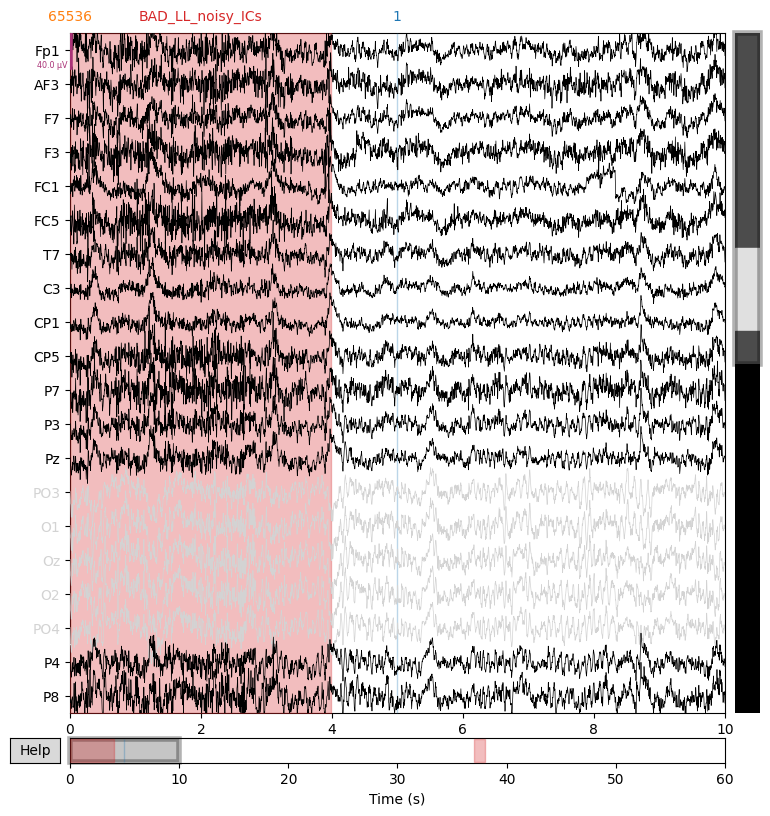

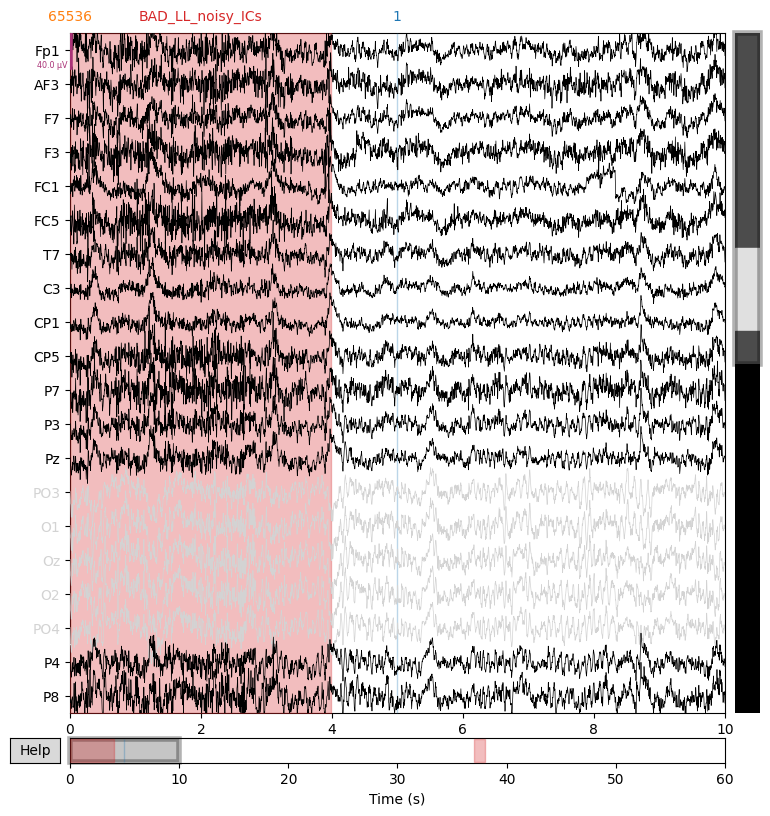

In [9]:
cleaned_raw = rejection_policy.apply(pipeline)
cleaned_raw.plot()

## Save the PyLossless Derivative

Let's save our pipeline output to disk. We need to use our
:class:`~mne_bids.BIDSPath` object to set up a derivatives path to save the
pipeline output to:



In [10]:
derivatives_path = pipeline.get_derivative_path(bids_path)
derivatives_path

BIDSPath(
root: ds002778/derivatives/pylossless
datatype: eeg
basename: sub-pd6_ses-off_task-rest_eeg_ll)

In [13]:
pipeline.save(derivatives_path, overwrite=True)

Writing 'ds002778/derivatives/pylossless/participants.tsv'...


Writing 'ds002778/derivatives/pylossless/participants.json'...
Writing 'ds002778/derivatives/pylossless/sub-pd6/ses-off/eeg/sub-pd6_ses-off_space-CapTrak_electrodes.tsv'...
Writing 'ds002778/derivatives/pylossless/sub-pd6/ses-off/eeg/sub-pd6_ses-off_space-CapTrak_coordsystem.json'...
The provided raw data contains annotations, but you did not pass an "event_id" mapping from annotation descriptions to event codes. We will generate arbitrary event codes. To specify custom event codes, please pass "event_id".
Used Annotations descriptions: [np.str_('1'), np.str_('65536'), np.str_('BAD_LL_noisy'), np.str_('BAD_LL_noisy_ICs')]
Writing 'ds002778/derivatives/pylossless/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_events.tsv'...
Writing 'ds002778/derivatives/pylossless/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_events.json'...
Writing 'ds002778/derivatives/pylossless/dataset_description.json'...
Writing 'ds002778/derivatives/pylossless/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_eeg.json

/home/zeph/Research2024/packages/pylossless/pylossless/pipeline.py:1129: RuntimeWarning: Converting data files to EDF format
  mne_bids.write_raw_bids(
/home/zeph/Research2024/packages/pylossless/pylossless/pipeline.py:1129: RuntimeWarning: EDF format requires equal-length data blocks, so 0.998 seconds of edge values were appended to all channels when writing the final block.
  mne_bids.write_raw_bids(


Writing 'ds002778/derivatives/pylossless/sub-pd6/ses-off/sub-pd6_ses-off_scans.tsv'...
Wrote ds002778/derivatives/pylossless/sub-pd6/ses-off/sub-pd6_ses-off_scans.tsv entry with eeg/sub-pd6_ses-off_task-rest_eeg.edf.
Writing ICA solution to /home/zeph/Research2024/ds002778/derivatives/pylossless/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_ica1_ica.fif...
Writing ICA solution to /home/zeph/Research2024/ds002778/derivatives/pylossless/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_ica2_ica.fif...


## Clean up




In [ ]:
##shutil.rmtree(bids_path.root)
##config_path.unlink()